In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("names.txt", 'r') as file:
    words = file.read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [5]:
vocab_size = len(itos)
block_size = 3

for word in words[:5]:
    print(word)
    context = [0] * block_size
    for char in word + '.':
        ix = stoi[char]
        print(''.join(itos[c] for c in context), '--->', itos[ix])
        context = context[1:] + [ix]
        

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
vocab_size = len(itos)
block_size = 3
def build_dataset(words):
    X, Y  = [], []
    for w in words:
        context = [0] * block_size
        for char in w + ".":
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:]) 

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [7]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd)
# use gain for std (tanh), want to decrease the range between values
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
#give some entropy
b1 = torch.randn((n_hidden, ), generator=g) * 0.01
#to squeeze weights after tanh (-1, 1)
W2 = torch.randn((n_hidden,     vocab_size), generator=g) * 0.01
#initialize to zero
b2 = torch.randn((vocab_size, ), generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

12297


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1, its constant for batch in neuron, neutralize mean (x@w + b1) - (mean(x@w) + b1)
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi =  hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) #if h is close (-1, 1) then neurons do not learn from grad
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward() 
    
    lr = 0.1 if i < 1000_000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): 4f}')    
    lossi.append(loss.log10().item())
loss.item()

      0/ 200000:  3.314528
  10000/ 200000:  2.141546
  20000/ 200000:  2.548684
  30000/ 200000:  2.046500
  40000/ 200000:  1.923382
  50000/ 200000:  2.001173
  60000/ 200000:  2.233931
  70000/ 200000:  2.260029
  80000/ 200000:  2.532061
  90000/ 200000:  2.156819
 100000/ 200000:  1.893832
 110000/ 200000:  2.137511
 120000/ 200000:  2.141471
 130000/ 200000:  1.918683
 140000/ 200000:  2.414561
 150000/ 200000:  1.748861
 160000/ 200000:  1.874008
 170000/ 200000:  2.391768
 180000/ 200000:  2.381217
 190000/ 200000:  2.001561


1.8427159786224365

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'valid': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) #if h is close (-1, 1) then neurons do not learn from grad
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('valid')

train 2.0780162811279297
valid 2.38143253326416


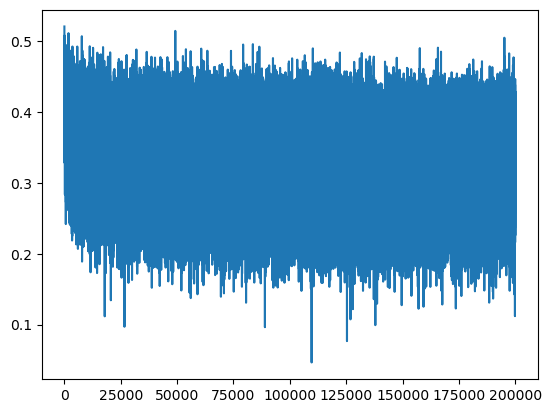

In [ ]:
plt.plot(lossi)
plt.show()

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(
            emb.view(emb.shape[0], -1) @ W1 + b1
        )
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[o] for o in out))

carmaviahjymmritzimlauglavyannahusleegahnyadam.
sartingquicnexmungwaiziav.
quillyah.
gmonziedelgauksulivea.
quaviahjauwogdettenigaq.
gulivsa.
zematzi.
qwette.
zymaryahpaubbygaigsya.
quallawouxncejshauxakfaxnakzlyanniah.
zoebertvia.
gulndeamtzliannathenlivyonnelviahdayahzyruzwyubdic.
zohgpraviyaqwikelviahzyriahdau.
kyovangstezamdeemh.
kymq.
camorabellagnamnurziahcauralykzna.
quinlangelmeretclizajzyzwaxyiellawyunqyyah.
gxynchazzyzzyahzyrvikodallaughtisabrissellatzy.
qwe.
rogaunbfsauizavdod.
